In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1aba4f5f5e38c79c6b58c00f4fa197bfe8d2bebeb21c1c13fc96d1801b27ec62
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("Proyecto_Final").getOrCreate()

In [ ]:
data_path = '/content/drive/MyDrive/Proyecto Final/Proyecto BigData/'

data = spark.read.options(inferSchema='True',delimiter=',', header=True).csv(data_path + 'Air_Traffic_Passenger_Statistics.csv')
data.take(2)

[Row(Activity Period=200507, Operating Airline='ATA Airlines', Operating Airline IATA Code='TZ', Published Airline='ATA Airlines', Published Airline IATA Code='TZ', GEO Summary='Domestic', GEO Region='US', Activity Type Code='Deplaned', Price Category Code='Low Fare', Terminal='Terminal 1', Boarding Area='B', Passenger Count=27271, Adjusted Activity Type Code='Deplaned', Adjusted Passenger Count=27271, Year=2005, Month='July'),
 Row(Activity Period=200507, Operating Airline='ATA Airlines', Operating Airline IATA Code='TZ', Published Airline='ATA Airlines', Published Airline IATA Code='TZ', GEO Summary='Domestic', GEO Region='US', Activity Type Code='Enplaned', Price Category Code='Low Fare', Terminal='Terminal 1', Boarding Area='B', Passenger Count=29131, Adjusted Activity Type Code='Enplaned', Adjusted Passenger Count=29131, Year=2005, Month='July')]

In [ ]:
data.show(5)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|GEO Region|Activity Type Code|Price Category Code|  Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|        US|          Deplaned|          

In [ ]:
# 1. ¿Cuántas compañías diferentes aparecen en el fichero?
unique_companies_count = data.select("Operating Airline").distinct().count()
print("Número de compañías diferentes:", unique_companies_count)

# Mostrar todas las compañías únicas
unique_companies = data.select("Operating Airline").distinct()
unique_companies.show(unique_companies.count(), truncate=False)

Número de compañías diferentes: 77
+--------------------------------+
|Operating Airline               |
+--------------------------------+
|Icelandair                      |
|Ameriflight                     |
|Cathay Pacific                  |
|Aeromexico                      |
|Etihad Airways                  |
|Philippine Airlines             |
|United Airlines - Pre 07/01/2013|
|Turkish Airlines                |
|Swiss International             |
|Independence Air                |
|Miami Air International         |
|Air France                      |
|Japan Airlines                  |
|Midwest Airlines                |
|Atlas Air, Inc                  |
|JetBlue Airways                 |
|China Eastern                   |
|Mexicana Airlines               |
|Air Canada                      |
|Allegiant Air                   |
|Northwest Airlines              |
|Sun Country Airlines            |
|Evergreen International Airlines|
|Horizon Air                     |
|United Airlines    

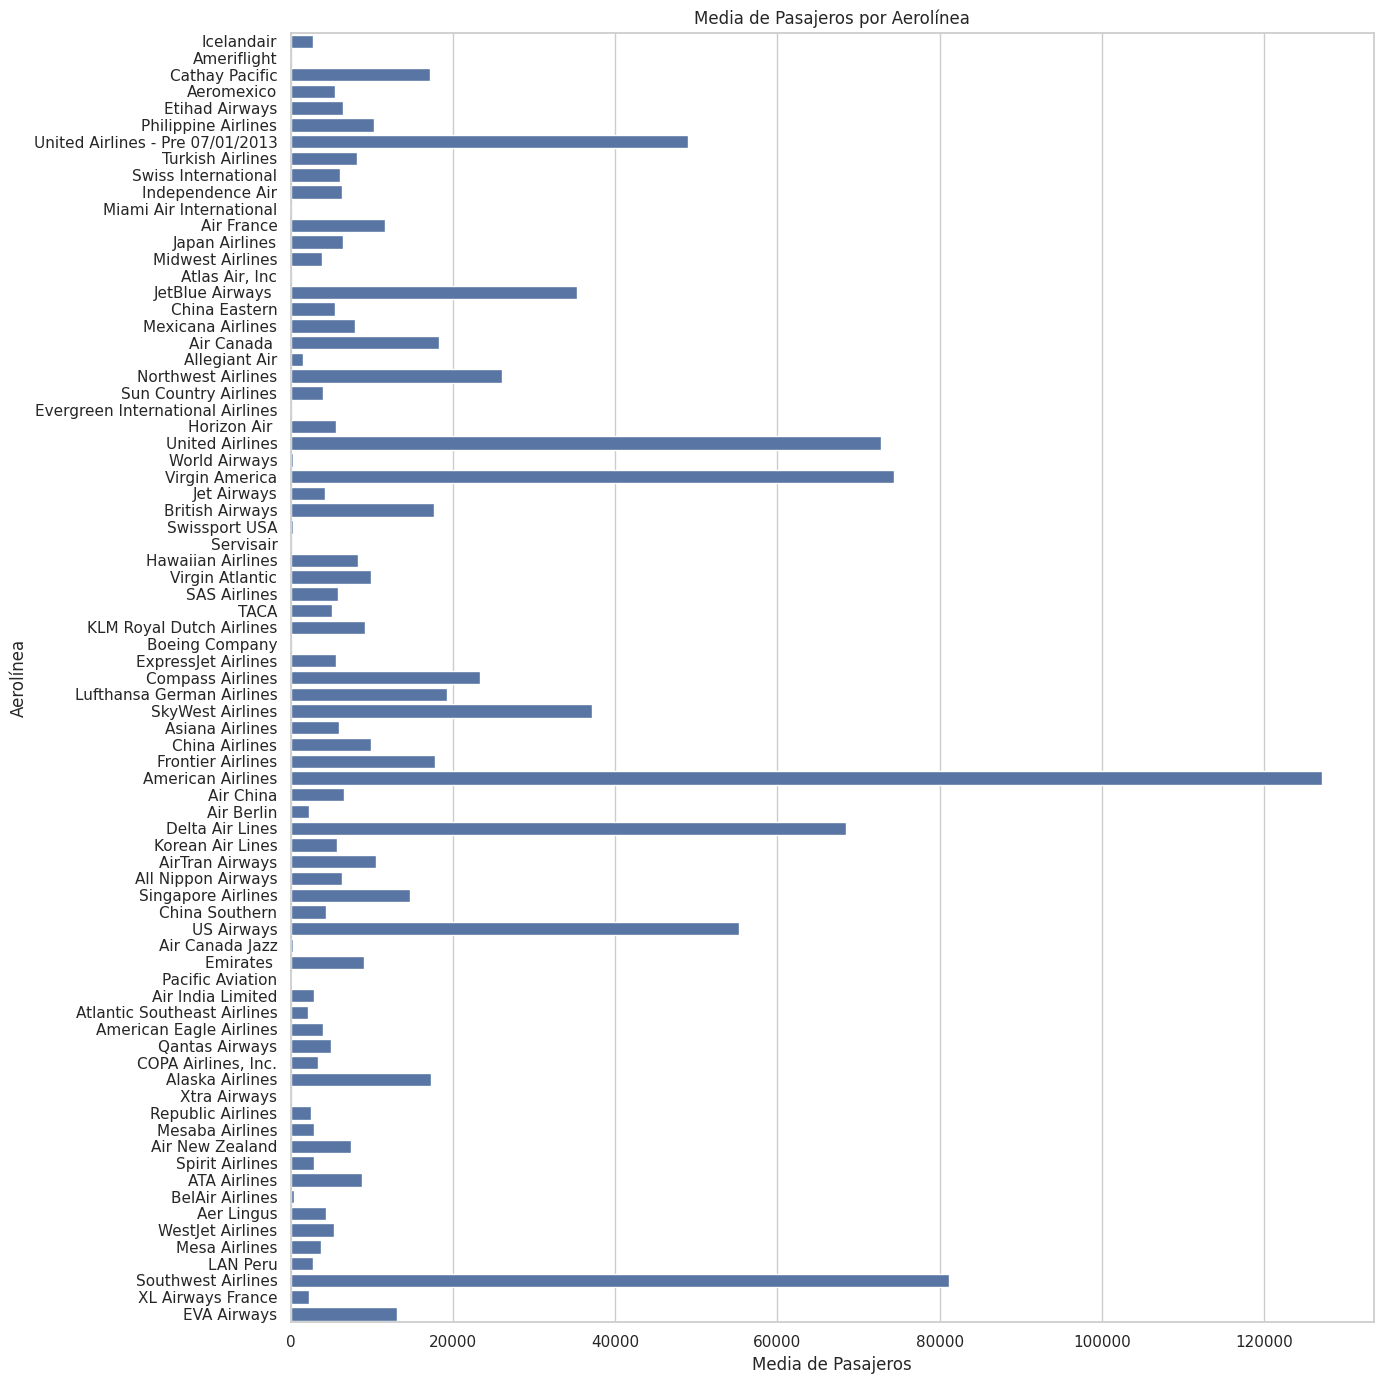

In [ ]:
# 2. ¿Cuántos pasajeros tienen de media los vuelos de cada compañía?
average_passengers_per_airline = data.groupBy("Operating Airline").agg(avg("Passenger Count").alias("Average Passenger Count"))
#average_passengers_per_airline.show(average_passengers_per_airline.count(), truncate=False)

# Convertir el DataFrame de PySpark a un DataFrame de Pandas
average_passengers_per_airline_pd = average_passengers_per_airline.toPandas()

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(14, 14))
ax = sns.barplot(x="Average Passenger Count", y="Operating Airline", data=average_passengers_per_airline_pd)

# Configurar el título y las etiquetas de los ejes
plt.title('Media de Pasajeros por Aerolínea')
plt.xlabel('Media de Pasajeros')
plt.ylabel('Aerolínea')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
# 3. Eliminar registros duplicados por el campo “GEO Región”, manteniendo sólo aquel con mayor número de pasajeros
df_sorted = data.orderBy(col("GEO Region"), col("Passenger Count").desc())
df_deduplicated = df_sorted.dropDuplicates(["GEO Region"])

# Mostrar el DataFrame deduplicado
df_deduplicated.show(df_deduplicated.count(), truncate=False)

+---------------+--------------------------------+---------------------------+--------------------------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-------+
|Activity Period|Operating Airline               |Operating Airline IATA Code|Published Airline               |Published Airline IATA Code|GEO Summary  |GEO Region         |Activity Type Code|Price Category Code|Terminal     |Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month  |
+---------------+--------------------------------+---------------------------+--------------------------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-------+
|200708         |United Airline

In [ ]:
# 4. Volcar los resultados a un archivo CSV
output_path_avg = "/content/drive/MyDrive/Proyecto Final/Proyecto BigData/average_passengers_per_airline.csv"
output_path_deduplicated = "/content/drive/MyDrive/Proyecto Final/Proyecto BigData/deduplicated_geo_region.csv"

In [ ]:
# Escribir los resultados en archivos CSV
average_passengers_per_airline.write.csv(output_path_avg, header=True, mode="overwrite")
df_deduplicated.write.csv(output_path_deduplicated, header=True, mode="overwrite")